# Loading KITTY dataset! 
 *Date 11/7/2020*
 
 This files provides instructions and functions to : 
 - Load the kitti data files.
 - Transform data to different coordinate systems (every sensor has its own coordinate system).
 - Visualize the 3D bounding boxes on top of the point cloud data.
 - Visualize 2D bounding boxes on image frame.
 - Visualize 3D bounding boxes on image frame.
 - Visualize point cloud points on image frame.
 - Crop point cloud keeping only points visible in the image frame.
 
 

 


## Importing the necessary libraries


 - __Numpy : Matrix structures, matrix operations__
 - __Open3d : Pointcloud visualizations__
 - __PIL : To load image files__
 - __MatPlotLib : To display image files__

*Also, setting some global variables such as the directory where the files are located and the names of the subdirectories that are used. In this loader we will use the images from :*
 - *camera_2 (colored camera images)*
 - *the lidar sensor (velodyne)*
 - *the labels for the bounding boxes (both 2D and 3D)*
 - *the calibration files*

In [1]:
## Some libraries are imported later in the file 
## because we don't need them all from the start.

## Import Section for the first part

#importing primary libraries
import numpy as np
from PIL import Image # for reading image files
import open3d as o3d
from open3d.j_visualizer import JVisualizer # to use open3d with jupyter 
                                            # TO DO : FIX j_visualizer
                                            # currently using normal o3d visualizer

#importing secondary libraries
import os
from math import sin, cos
from pprint import pprint # to display dictionaries in pretty format


# Setting global variables
basedir = './training' 
left_cam_rgb = 'image_2'
label = 'label_2'
velodyne = 'velodyne'
calib = 'calib'


## Loading the kitty files

Load KITTI image (.png), calibration (.txt), velodyne (.bin), and label (.txt),  files
corresponding to a frame.

__Input__ : The raw frame name (without any subfix)


In [2]:
def loadKittiFiles(frame):
    # loading the image file
    imageDir = os.path.join(basedir, left_cam_rgb, frame + '.png')
    left_cam = Image.open(imageDir).convert ('RGB')
    
    #loading velodyne file
    veloDir = os.path.join(basedir, velodyne, frame + '.bin')
    velo = np.fromfile(veloDir, dtype=np.float32).reshape(-1, 4).transpose()
    
    #loading calibration file
    caliDir = os.path.join(basedir, calib, frame + '.txt')
    calib_data = {} # creating a dictionary to store the calibration data
    with open (caliDir, 'r') as f :
        for line in f.readlines():
            if ':' in line :
                key, value = line.split(':', 1)
                calib_data[key] = np.array([float(x) for x in value.split()])
                
    #loading label file
    labelDir = os.path.join(basedir, label, frame + '.txt')
    label_data = {} # creating a dictionary to store the label data
    with open (labelDir, 'r') as f :
        for line in f.readlines():
            if len(line) > 3:
                key, value = line.split(' ', 1)
                if key in label_data.keys() :
                    label_data[key].append([float(x) for x in value.split()] )
                else:
                    label_data[key] =[[float(x) for x in value.split()]]
    # storing label data as numpy arrays
    for key in label_data.keys():
        label_data[key] = np.array(label_data[key])
        
    return left_cam, velo, label_data, calib_data


## Testing the loading function

In [3]:
image, velo, label_data, calib_data = loadKittiFiles("000000")

print("Image : ")
print(image)

print("\nVelo : ")
print(velo)

print("\nLabel Data : ")
pprint(label_data)

print("\nCalibration Data : ")
pprint(calib_data)

Image : 
<PIL.Image.Image image mode=RGB size=1224x370 at 0x7FAA700DF048>

Velo : 
[[ 1.8324e+01  1.8344e+01  5.1299e+01 ...  3.7180e+00  3.7140e+00
   3.9670e+00]
 [ 4.9000e-02  1.0600e-01  5.0500e-01 ... -1.4060e+00 -1.3910e+00
  -1.4740e+00]
 [ 8.2900e-01  8.2900e-01  1.9440e+00 ... -1.7370e+00 -1.7330e+00
  -1.8570e+00]
 [ 0.0000e+00  0.0000e+00  0.0000e+00 ...  3.4000e-01  4.1000e-01
   0.0000e+00]]

Label Data : 
{'Pedestrian': array([[ 0.0000e+00,  0.0000e+00, -2.0000e-01,  7.1240e+02,  1.4300e+02,
         8.1073e+02,  3.0792e+02,  1.8900e+00,  4.8000e-01,  1.2000e+00,
         1.8400e+00,  1.4700e+00,  8.4100e+00,  1.0000e-02]])}

Calibration Data : 
{'P0': array([707.0493,   0.    , 604.0814,   0.    ,   0.    , 707.0493,
       180.5066,   0.    ,   0.    ,   0.    ,   1.    ,   0.    ]),
 'P1': array([ 707.0493,    0.    ,  604.0814, -379.7842,    0.    ,  707.0493,
        180.5066,    0.    ,    0.    ,    0.    ,    1.    ,    0.    ]),
 'P2': array([ 7.070493e+02,  0.00

## Visualizing the pointCloud using open3d

In [4]:
# creating a point cloud object
pcd = o3d.geometry.PointCloud()

# reshaping velo -> 
# dimensions should be : N x 3
# where N: number of points
# 3 : (x, y, z) coordinates

velo_to_pcd = velo.transpose()[:,0:3]

# adding point coordinates from numpy  
pcd.points = o3d.utility.Vector3dVector(velo_to_pcd)

# adding a small sphere with radius r=0.3 at the origin (0,0,0)
mesh_sphere = o3d.geometry.TriangleMesh.create_sphere(radius=0.3)
mesh_sphere.paint_uniform_color([0.3, 0.3, 0.3])

# adding a coordinate space at the origin
# x-axis -> red
# y-axis -> green
# z-axis -> blue
mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(
        size=3, origin=[0, 0, 0])

# uncomment these lines to use jupyter JVisualizer
# currently not working so using normal visualizer instead
""" 
# creating a visualizer 
visualizer = JVisualizer()
# adding the point cloud to the visualizer
visualizer.add_geometry(pcd)
# display the result
visualizer.show()
"""
# normal visualizer
# takes as input a list with the objects that we wish to render
o3d.visualization.draw_geometries([pcd,mesh_sphere, mesh_frame])

## Coordinate Frames of The Data

Ever sensor of the vehicle has its own coordinate frame, where the sensor is located in the origin.
In the calibration files the matrices are provided to transfer the data from one coordinate frame to the one of another sensor. 

The coordinate frames and the calibration matrices used for each case are displayed in the image below:

![title](jupyterImages/coordinateFrames.png)

We consider the coordinate system that has its center at the camera_0 and has the axis alignment as show at the position of camera_0 in the picture to be the global coordinate system.

## Loading the 3D bounding boxes 

In the label file the coordinates of the bounding boxes are provided. To define a bounding box we use its height, width, length and the coordinates of its center (in the global coordinate system). The bounding boxes are calculated in object frame (coordinate system with center at the center of the bounding box). Also, the angle of the bounding box is given. This angle represents the rotation that we need to apply to the bounding box to place it in the global coordinate system. 
The complete process of placing a 3D bounding box to the global coordinate system is to rotate it by the given angle then translate it so thats its center will move from the origin to the given global coordinates.












In [5]:
def boundingBoxToGlobal(label):
    # reading the bounding box information
    h = label[7]     # box width
    w = label[8]     # box height
    l = label[9]     # box length
    x = label[10]    # location (x)
    y = label[11]    # location (y)
    z = label[12]    # location (z)
    ry = label[13]   # yaw angle
    
    # constructing the rotation matrix
    R = np.array([ [+cos(ry), 0, +sin(ry)],
                 [0, 1,               0],
                 [-sin(ry), 0, +cos(ry)] ])
    
    # defining the bounding box corners (in local coordinate frame)
    x_corners = [l/2, l/2, -l/2, -l/2, l/2, l/2, -l/2, -l/2]
    y_corners = [0,0,0,0,-h,-h,-h,-h]
    z_corners = [w/2, -w/2, -w/2, w/2, w/2, -w/2, -w/2, w/2]
    
    # creating a numpy array containing all the corners
    corners3d = np.array([x_corners, y_corners, z_corners])
    
    # multiplying with the rotation matrix (rotating around the y-axis)
    corners3d = R.dot(corners3d)
    
    # The 3d bounding box is in the correct axis alignment but it 
    # in the origin of the axes, so we need to translate it to the 
    # correct position.
    corners3d[0, :] += x
    corners3d[1, :] += y
    corners3d[2, :] += z
    
    return corners3d
    

## Transfering the bounding boxes to velodyne coordinate frame

To visualize the bounding boxes on the point cloud we need to have them both on the same coordinate space.
This means either transforming the pointcloud data to the global coordinate space or the bounding boxes to the velodyne coordinate space. 

Open3d used the openGL format for its own coordinate frame. Meaning the z-axis is looking towards the camera, x-axis to the left and y-axis up (up-vector). Of course, while moving the camera we can look at the point cloud and the bounding boxes from different angles but displaying it the velodyne coordinates gives us a better initial position-view.

Next, we create a funstion that takes as input a set of points and transform them from the global coordinate frame to the velodyne coordinate frame. This function takes as input the points and the calibration file. 


In [6]:
def globalToVelo(points, calib):
    
    # creating a 4x4 transformation matrix
    Tr_velo_to_cam = np.zeros((4,4))
    Tr_velo_to_cam[3,3] = 1
    
    # copying the rest transformation matrix elements from the calibration file
    Tr_velo_to_cam[:3,:4] = np.array(calib['Tr_velo_to_cam']).reshape(3,4)
    
    ## TO DO ##  -->  Add more detailed description on this part!
    # Rectifying matrix to go from global-space to camera-space (and the to velo-space)
    R0 = np.zeros((4,4))
    R0[3,3] = 1
    R0[0:3,0:3] = calib['R0_rect'].reshape(3,3)
    
    # Calculating the inverse matrix to go to global coordinate frame from the camera one.
    invR0 = np.linalg.inv(R0)
    
    
    # calculating the inverse matrix
    tr_global_to_velo = np.linalg.inv(Tr_velo_to_cam)
    
    # the points need to have a "w" dimension -> (x,y,z,w)
    # where w need to be equal to 1 for every point
    # also points need to have dimension 3xN or 4xN
    if points.shape[0] == 3:
        points_temp = np.ones((4, points.shape[1]))
        points_temp[0:3,:] = points[:,:]
        points = points_temp
    else:
        points[3,:] = 1
        
    
    # Multiplying with the transformation matrices
    points = invR0.dot(points) 
    points_out = tr_global_to_velo.dot(points)
    
 
    return points_out


## Visualizing a bounding box on point cloud

Last but not least, we need to visualize the bounding box using open3d. 
We are going to use a set of linesets to create a 3D box. 

This is implemented with the next function that takes as unput the 3D coordinates of the corners of the 
bounding box and constructs a open3d lineset. 


In [7]:
def create_o3dBB(corners3d):
    
    #defining the connectivity of the points
    lines = [
                [0, 1], [1, 5], [5, 4], [4, 0], #face 1
                [0, 1], [1, 2], [2, 3], [3, 0], #face 2
                [1, 2], [2, 6], [6, 5], [5, 1], #face 3
                [2, 3], [3, 7], [7, 6], [6, 2], #face 4
                [3, 0], [0, 4], [4, 7], [7, 3]  #face 5 
            ]
    #assigning a color
    colors = [[1, 0, 0] for i in range(len(lines))]
    
    #creating the open3d lineset
    line_set = o3d.geometry.LineSet(
    points=o3d.utility.Vector3dVector(corners3d.transpose()),
    lines=o3d.utility.Vector2iVector(lines),
    )
    line_set.colors = o3d.utility.Vector3dVector(colors)

    return line_set


### Putting it all together

Now that all the necessary functions are implemented we are ready to read all the bounding boxes on a scene and visualize them on top of the point cloud. 

In [8]:
    ## Main ##

# Selecting a frame :
frame = "000000"

# Reading the data for the specific frame
left_cam, velo, label_data, calib_data = loadKittiFiles(frame)

# Creating an open3d pointCloud to store the velo data
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(velo.transpose()[:,0:3])

# creating a list to store all the objects that will be rendered on the scene
renders = [pcd] 

# constracting the bounding box for all visible objects
# for every object category
for k in label_data.keys():
    # for every instance of this category
        for i in range(label_data[k].shape[0]):
            p = label_data[k][i][:]
            # transforming bounding box to global coordinates
            corners3d = boundingBoxToGlobal(label_data[k][i][:])
            # transforming bounding box to velo coordinates
            corners3d = globalToVelo(corners3d, calib_data)
            # creating a lineset to represent the bounding box
            line_set = create_o3dBB(corners3d[0:3,:])
            # adding the bounding box to the bounding box list
            renders.append(line_set)

# visualizing the scene
o3d.visualization.draw_geometries(renders)

## Visualizing bounding boxes on images

Now we want to visualize both the 2D and the 3D bounding boxes on the images of the scenes.

In [9]:
## Importing Section for the second part.

# Importing matplotlib to visualize image results
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines

## Displaying a Rectangle patch using MatPlotLib

We will use the matplotlib library to draw rectangles on top of the images.   
We will create a fuction that takes as input the axis of a plot and the rectagnle coordinates and displays the rectangle on the plot. Then we will test our function with a sample image.

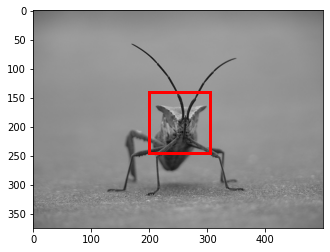

In [10]:
def dispRectOnIm(ax, xy, w, h, linewidth = 1, edgecolor ='r', facecolor='none' ):
    # ax -> the axis from a plot or a subplot
    # xy = (x, y) -> the bottom-left rectangle coordinates
    # w -> rectangle width
    # h -> rectangle height
    
    # Create a Rectangle Patch
    rectangle = patches.Rectangle(xy, w, h, linewidth=linewidth, edgecolor=edgecolor,facecolor=facecolor)
    
    # Add the patch to the Axes
    ax.add_patch(rectangle)
    
    
    
    ## Test ##
    
#Loading the image
im = np.array(Image.open('./samples/stinkbug.png'), dtype=np.uint8)

#Create figure and axes
fig,ax = plt.subplots()

# Display the image
ax.imshow(im) 

# defining the rectangle parame
dispRectOnIm(ax, (200,140), 105, 105, linewidth=3)

## Loading 2D bounding boxes
 
Let's create a function to load the 2D bounding boxes from the label file. 

In [11]:
def load2DBoxes(labels):
    
    # creating a list to store all the bounding boxes
    bbs = []
    
    # for exery key of the disctionary
    for k in labels.keys():
        # for every instance in this category
        for i in range(labels[k].shape[0]):
            # reading the bounding box coordinates
            x1 = labels[k][i][3] # left
            y1 = labels[k][i][4] # top
            x2 = labels[k][i][5] # right
            y2 = labels[k][i][6] # bottom
            
            # assigning different color depending on the category
            if k == "Car":
                color = 'r' 
            elif k == 'Pedestrian':
                color = 'g'
            elif k == 'Cyclist':
                color = 'b'
            else:
                color = 'y'

                
            # storing the bounding box in the appropriate format
            bbs.append([(x1,y2),        (x2-x1),  (y1- y2),  color])
            #            TUPLE           width     height    color
            #       WITH BOTTOM-LEFT
            #         COORDINATES
    return bbs
        

## Displaying 2D bounding boxes

Now let's display the current frame with all the labeled bounding boxes

{'P0': array([707.0493,   0.    , 604.0814,   0.    ,   0.    , 707.0493,
       180.5066,   0.    ,   0.    ,   0.    ,   1.    ,   0.    ]),
 'P1': array([ 707.0493,    0.    ,  604.0814, -379.7842,    0.    ,  707.0493,
        180.5066,    0.    ,    0.    ,    0.    ,    1.    ,    0.    ]),
 'P2': array([ 7.070493e+02,  0.000000e+00,  6.040814e+02,  4.575831e+01,
        0.000000e+00,  7.070493e+02,  1.805066e+02, -3.454157e-01,
        0.000000e+00,  0.000000e+00,  1.000000e+00,  4.981016e-03]),
 'P3': array([ 7.070493e+02,  0.000000e+00,  6.040814e+02, -3.341081e+02,
        0.000000e+00,  7.070493e+02,  1.805066e+02,  2.330660e+00,
        0.000000e+00,  0.000000e+00,  1.000000e+00,  3.201153e-03]),
 'R0_rect': array([ 0.9999128 ,  0.01009263, -0.00851193, -0.01012729,  0.9999406 ,
       -0.00403767,  0.00847068,  0.00412352,  0.9999556 ]),
 'Tr_imu_to_velo': array([ 9.999976e-01,  7.553071e-04, -2.035826e-03, -8.086759e-01,
       -7.854027e-04,  9.998898e-01, -1.482298e-02,

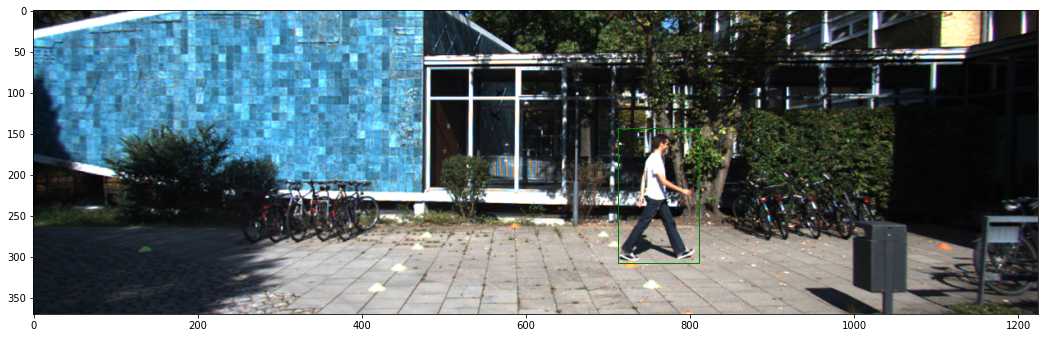

In [195]:
# Re-reading the data, so we don't have to run any code above to 
# test this part on different frames

# Selecting a frame :
frame = "000000"

# Reading the data for the specific frame
left_cam, velo, label_data, calib_data = loadKittiFiles(frame)

pprint(calib_data)

# turning the image to numpy format
im = np.array(left_cam)

#creating figure and axes
fig,ax = plt.subplots(1, figsize=(18, 16))

# Display the image
ax.imshow(im)

# calculate all bounding boxes
bbs = load2DBoxes(label_data)

#display bounding boxes
for bb in bbs:
    dispRectOnIm(ax, bb[0], bb[1], bb[2], edgecolor=bb[3])

## Displaying 3D bounding boxes on image
 
Now we will try to display a 3D bounding box on an RGB image, using the provided projection matrices.   
The camera we are using is the camera_2, so we will use the projection matrices related to that camera. 

This projection matrix is stored in the **calib_data** dictionary, and the key value is **P2**.

__STEPS:__
- Transform bounding boxes to global coordinates (already implemented)
- Keep bounding boxes for objects that are in front of the camera
- Project these bounding boxes to the image plane using the projection matrix. 
- Draw the boxes

### Projecting the 3D bounding box coordinates to the image plane

Multiplying the 3D coordinates with the projection matrix to map them on the 2D image plane

In [196]:
def projectBoundingBoxToPlane(bb3d, P):
    # given the corner coordinates of a 3d bounding box and a projection matrix
    # we project the bounding box to te image plane
    # bb3d dimensions should be (3,N)
    
    # augmenting bb3d dimensions - adding w dimension
    pts3d = np.ones((4, bb3d.shape[1]))
    pts3d[0:3,:] = bb3d
    
    #project to image
    pts2d = P.reshape(3,4).dot(pts3d)
    pts2d[0, :] = np.divide(pts2d[0, :], pts2d[2, :])
    pts2d[1, :] = np.divide(pts2d[1, :], pts2d[2, :])
    
    return pts2d[0:2, :] 
    

### Drawing the 2D projection of the 3D bounding box 

We give as input to this function :
 - the axis of a subplot, 
 - the coordinates of the 3d bounding box
 - the projection matrix (from the calibration data)
 - the desired color of the 3d bounding box that indicates the class of the object inside the bounding box

In [197]:
def drawBB3D(ax, corners3d, P, color ):
    
    # the face indexes are the same and are computed based on the way we create 
    # the bounding boxes in function - boundingBoxToGlobal -
    face_idx = np.array([[0,1,5,4],   # front face
                         [1,2,6,5],   # left face
                         [2,3,7,6],   # back face
                         [3,0,4,7]])  # right face
    
    # Projecting 3d bounding box to plane
    corners2d = projectBoundingBoxToPlane(corners3d, P)
    
    
    # Drawing the lines connecting the edge poitns
    # and adding them to ax
    
    # for each face of the cube
    for i in range(4):
        # for each corner
        for j in range(4):
            l = lines.Line2D([corners2d[0,face_idx[i][j]],
                                      corners2d[0,face_idx[i][(j+1)%4]]],  # x coordinates
                              [corners2d[1,face_idx[i][j]],
                                      corners2d[1,face_idx[i][(j+1)%4]]],  # y coordinates
                            color = color)  
            # adding line to axes
            ax.add_line(l)
            

### Creating a function that assigns color on the bounding boxes based on their semantic class

In [198]:
# Creating a function for assigning color
def assignColor(k):
    if k == "Car":
        color = 'r' 
    elif k == 'Pedestrian':
        color = 'g'
    elif k == 'Cyclist':
        color = 'b'
    else:
        color = 'y'
    return color


### Putting it all together

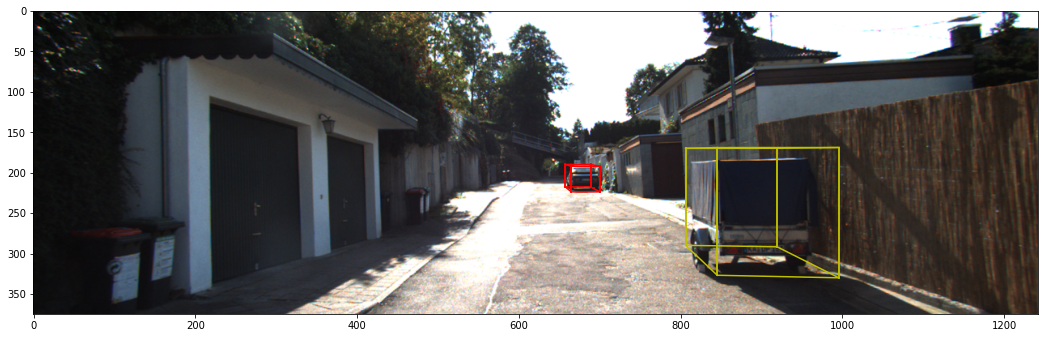

In [211]:
# Re-reading the data, so we don't have to run any code above to 
# test this part on different frames

# Selecting a frame :
frame = "000002"

# Reading the data for the specific frame
left_cam, velo, label_data, calib_data = loadKittiFiles(frame)

# finding the projection matrix 
P = calib_data["P2"]

# turning the image to numpy format
im = np.array(left_cam)

#creating figure and axes
fig,ax = plt.subplots(1, figsize=(18, 16))

# Display the image
ax.imshow(im)

# Display 3D bounding boxes
# for every object category
for k in label_data.keys():
    # for every instance of this category
        for i in range(label_data[k].shape[0]):
            # transforming bounding box to global coordinates
            corners3d = boundingBoxToGlobal(label_data[k][i][:])
            # keeping bounding boxes that are in front of the camera
            # meaning : having all points with z coorinate >= 0.1
            if np.all(corners3d[2,:] >= 0.1):
                # assigning color
                color = assignColor(k)
                # drawing the 3d bounding box
                drawBB3D(ax, corners3d, P, color)

## Projecting and Visualizing Velodyne point cloud on the image

We will project the lidar points to the image plane. In this way we achive 2 goals.
 - We create something like a depth map of the image (assigning a depth value to specific image areas)
 - We can use this information to only the keep the lidar points that are inside the image field of view. Since these are the only labeled points and use only these for trainning our neural network. (Making some serious saving in storage)
 
### Projecting Velodyne point cloud on the image plane

STEPS:
- Firstly, we need to transform the velodyne point cloud to the cameraspace. To do that we will use
    - the transformation matrix provided with th calibration data : *Tr_velo_to_cam*
    - the *R0_rect* transformation matrix (also provided in the calibration data)
- Then, we will use the projection matrix (a.k.a. camera matrix), with dimensions 3x4, to project the points to the camera plane.

In [212]:
def veloToImage(velo, calib):
    
    # Transforming velo to global coordinates
    velo_to_global = np.zeros((4,4))
    velo_to_global[3,3] = 1
    velo_to_global[:3,:4] = calib['Tr_velo_to_cam'].reshape(3,4)
    
    velo_glob = velo_to_global.dot(velo)
    
    # Using the rectification matrix R0_rect 
    r0_rect = np.zeros((4,4))
    r0_rect[3,3] = 1
    r0_rect[:3,:3] = calib['R0_rect'].reshape(3,3)
    
    velo_glob_rect = r0_rect.dot(velo_glob)
    
    # Using the projection matrix (camera matrix) to project on the image plane
    p2 = calib['P2'].reshape(3,4)
    
    velo_im = p2.dot(velo_glob_rect)
    
    
    
    # Normalizing (using w dimension)
    velo_im[0,:] = np.divide(velo_im[0,:], velo_im[2,:])
    velo_im[1,:] = np.divide(velo_im[1,:], velo_im[2,:])
    
    return velo_im[0:2,:]


### Filtering the points of the point cloud

We need to filter out the points of the point cloud that are not visible in the camera fov (field of view).

These points are seperated in two cases: 
 - The points located at the back of the vehicle 
 - The points that are located in frond of the vehicle but not in the fov of the camera

In [213]:
# Keeping points in front of the camera
keeperIndexes = (velo[0, :] > 0)
velo_frond = velo[:, keeperIndexes]

# Projecting point cloud to image
velo_im = veloToImage(velo_frond, calib_data)

# Finding image dimensions to keep only the points inside the image fov
image_shape = np.array(left_cam).shape[0:2] # keeping x, y max dimensions

# Filtering points to keep only points that fit in the image frame
keeperIndexes = (
        (velo_im[0, :] < image_shape[1])
        & (velo_im[0, :] >= 0)
        & (velo_im[1, :] < image_shape[0])
        & (velo_im[1, :] >= 0)
    )
velo_im = velo_im[:, keeperIndexes]

### Assigning a per point color to display the point cloud on the image

We need a criteria to colorize the projected points on the image. In this case we will choose the euclidean distance of the points (in the 3D coordinates) from the origin (0,0,0).

In [214]:
# we are using the velo front because it only contains the points that are in front of the camera 
# and the points are still in the 3D coordinate system.
# Then we will apply the same filtering we applied in the image plane to keep only the visible points
perPointColor = np.zeros((velo_frond.shape[1]))
perPointColor = np.sum(np.abs(velo_frond[0:3,:].transpose())**2,axis=-1)**(1./2)
# Normalizing values to be in range [0,1]
perPointColor = perPointColor / np.max(perPointColor) 
# Filtering the points
perPointColor = perPointColor[keeperIndexes]

### Visualizing points on image 

We will create a funcion that will take as input
 - an image,
 - a set of 2D points and
 - a per point color vector  
 
and displays the points on the image.


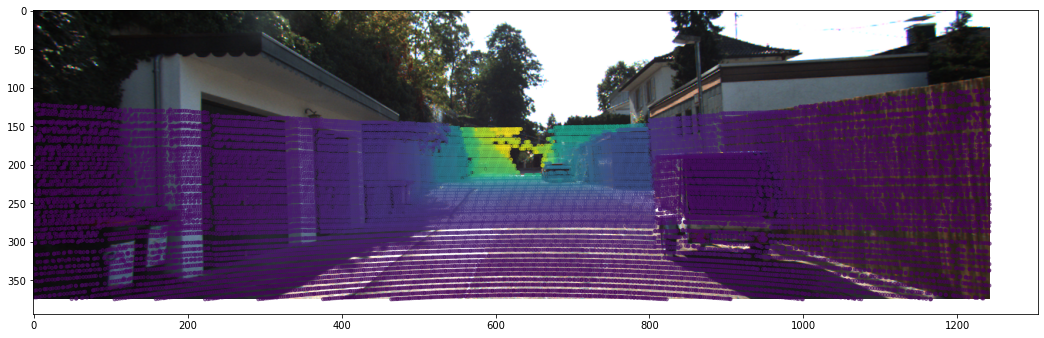

In [215]:
# to use color maps
import matplotlib.cm as cm


def visPointsOnImage(image, points, perPointColor):
    # image : is the camera image
    # points : are the points to be scattered on the image
    # perPointColor : the criteria to colorize the points
    
    fig,ax = plt.subplots(1, figsize=(18, 16))
    ax.imshow(np.array(left_cam))
    ax.scatter(velo_im[0,:], velo_im[1,:], s=10.0, c = perPointColor,  alpha =0.5,  cmap='viridis')
    
    
 ## Test ##
visPointsOnImage(left_cam, velo_im, perPointColor )    

### Croping the point cloud keeping only the visible points
Lastly, we will crop the point cloud, keeping only the visible points as mentioned above.

In [216]:
# filtering velo_front (points in front of the camera)
# keeping the visible points using the same filter calculated above
velo_vis = velo_frond[0:3, keeperIndexes]

# creating a open3D pointCloud for visualization
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(velo_vis.transpose())

# displaying the pointcloud
o3d.visualization.draw_geometries([pcd])